In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import sys
sys.path.insert(0, '../')

import structure_model_lib
import data_utils
import paragami

In [2]:
from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

In [3]:
np.random.seed(53453)

# Draw data

In [4]:
n_obs = 50
n_loci = 40
n_pop = 4

# population allele frequencies
true_pop_allele_freq = np.random.random((n_loci, n_pop))

# individual admixtures
true_ind_admix_propn = np.random.dirichlet(np.ones(n_pop) / n_pop, size = (n_obs))

In [5]:
clustering_indx = data_utils.cluster_admix_get_indx(true_ind_admix_propn)
true_ind_admix_propn = true_ind_admix_propn[clustering_indx, :]

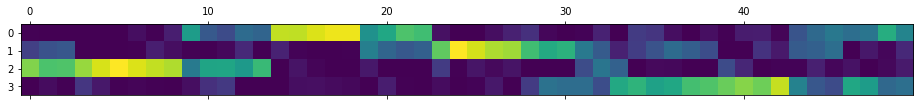

In [6]:
plt.matshow(true_ind_admix_propn.T)

In [7]:
g_obs = data_utils.draw_data(true_pop_allele_freq, true_ind_admix_propn)

In [8]:
# np.save('../data/true_ind_admix_propn', true_ind_admix_propn)
# np.save('../data/true_pop_allele_freq', true_pop_allele_freq)
# np.save('../data/simulated_genotypes', g_obs)

In [9]:
g_obs.shape

(50, 40, 3)

# Get prior

In [10]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [11]:
k_approx = 4


In [12]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [13]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (40, 4, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (50, 3) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (50, 3) (lb=0.0001, ub=inf)


## Initialize 

In [14]:
vb_params_dict = structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict)

In [15]:
# take a look at init 
e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                    vb_params_dict['ind_mix_stick_propn_mean'], 
                    vb_params_dict['ind_mix_stick_propn_info'],
                    gh_loc, gh_weights)

e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])

In [16]:
if k_approx < 6: 
    # find minimizing permutation 
    # only feasible if k_approx is small, 
    # else my computer freezes
    perm = data_utils.find_min_perm(e_pop_freq, true_pop_allele_freq, axis = 1)
else: 
    perm = np.arange(k_approx)
    
e_pop_freq = e_pop_freq[:, perm]
e_ind_admix = e_ind_admix[:, perm]

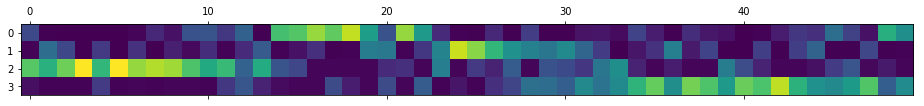

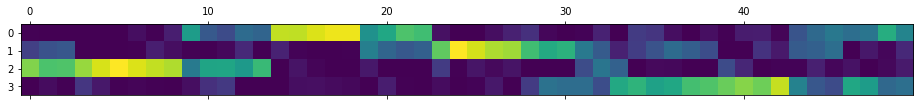

In [17]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

# Set up model

In [22]:
# get loss as a function of vb parameters
get_free_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=structure_model_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_free_vb_params_loss_cached = \
    lambda x : get_free_vb_params_loss(g_obs, x, prior_params_dict, gh_loc, gh_weights)

In [23]:
init_vb_free_params = vb_params_paragami.flatten(vb_params_dict, free = True)

In [24]:
structure_model_lib.get_kl(g_obs, vb_params_dict,
                   prior_params_dict, gh_loc, gh_weights)

5278.532804627065

In [25]:
get_free_vb_params_loss_cached(init_vb_free_params)

5278.532804627065

In [26]:
vb_opt_free_params = opt_lib.optimize_full(get_free_vb_params_loss_cached, init_vb_free_params,
                    bfgs_max_iter = 50, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
Iter 0: f = 5278.53280463
Iter 1: f = 5090.16881964
Iter 2: f = 4811.52285237
Iter 3: f = 4371.95372216
Iter 4: f = 3957.89086637
Iter 5: f = 3686.31815002
Iter 6: f = 3476.78734549
Iter 7: f = 3398.62470542
Iter 8: f = 3322.20253975
Iter 9: f = 3279.05381061
Iter 10: f = 3246.53826758
Iter 11: f = 3212.94761217
Iter 12: f = 3188.52480480
Iter 13: f = 3169.61136071
Iter 14: f = 3155.53109282
Iter 15: f = 3142.20586439
Iter 16: f = 3128.94434390
Iter 17: f = 3121.70691619
Iter 18: f = 3111.71138125
Iter 19: f = 3099.97354110
Iter 20: f = 3093.69187825
Iter 21: f = 3085.82038099
Iter 22: f = 3080.33573965
Iter 23: f = 3072.11060255
Iter 24: f = 3065.50159400
Iter 25: f = 3064.53194997
Iter 26: f = 3070.20880345
Iter 27: f = 3061.67785425
Iter 28: f = 3057.11513085
Iter 29: f = 3052.46350880
Iter 30: f = 3045.63949596
Iter 31: f = 3045.82173274
Iter 32: f = 3041.14156820
Iter 33: f = 3043.15377946
Iter 34: f = 3039.35572584
Iter 35: f = 3036.78853572
Iter 36: f = 3033.94

In [27]:
vb_opt_dict = vb_params_paragami.fold(vb_opt_free_params, free=True)

In [28]:
ind_mix_stick_propn_mean = vb_opt_dict['ind_mix_stick_propn_mean']
ind_mix_stick_propn_info = vb_opt_dict['ind_mix_stick_propn_info']
pop_freq_beta_params = vb_opt_dict['pop_freq_beta_params']

In [29]:
e_pop_allele_freq = pop_freq_beta_params[:, :, 0] / pop_freq_beta_params.sum(axis=2)

In [30]:
if k_approx < 6: 
    perm_best = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)
else: 
    perm_best = perm

([array([6., 4., 3., 6., 2., 5., 3., 0., 4., 7.]),
  array([ 7.,  0.,  6.,  2.,  2.,  3.,  5.,  0.,  5., 10.]),
  array([ 8.,  1.,  2.,  5.,  1.,  4.,  2.,  3.,  4., 10.]),
  array([5., 2., 4., 5., 4., 5., 2., 2., 3., 8.])],
 array([0.04033442, 0.13150695, 0.22267948, 0.31385201, 0.40502454,
        0.49619707, 0.5873696 , 0.67854213, 0.76971466, 0.86088719,
        0.95205972]),
 <a list of 4 Lists of Patches objects>)

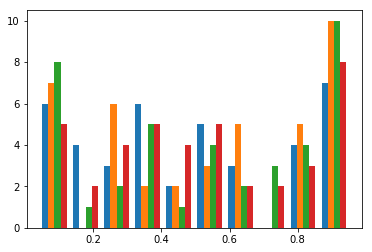

In [31]:
plt.hist(e_pop_allele_freq)

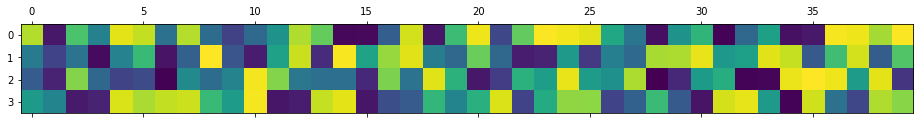

In [32]:
plt.matshow(e_pop_allele_freq[:, perm_best].T)

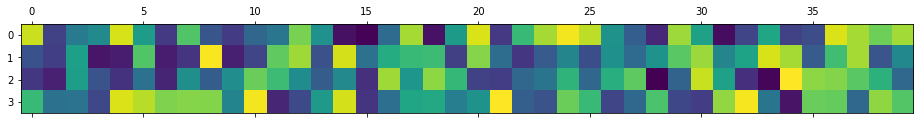

In [33]:
plt.matshow(true_pop_allele_freq.T)

In [34]:
e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        ind_mix_stick_propn_mean, ind_mix_stick_propn_info,
                        gh_loc, gh_weights)[:, perm_best]

In [35]:
e_ind_admix.argmax(axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 1, 0, 0])

In [36]:
true_ind_admix_propn.argmax(axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 0, 3, 3, 0, 0])

In [37]:
np.mean(e_ind_admix.argmax(axis=1) == \
       true_ind_admix_propn.argmax(axis=1))

0.82

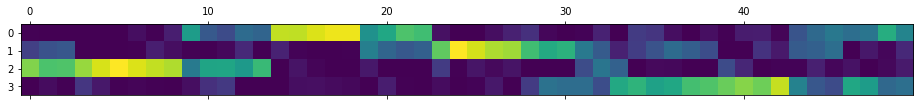

In [38]:
plt.matshow(true_ind_admix_propn.T)

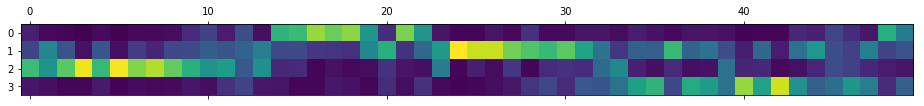

In [39]:
plt.matshow(e_ind_admix.T)